In [1]:
# repeating the principal component analysis but with different imputations for number of months food insecure
# imputing using the means should be the purest method.

In [2]:
# I couldn't find a good package that did what I had expected it to do so I did some investigation and experimentation
    # using a few. This was my favourite

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
% matplotlib inline
import statsmodels.multivariate.pca as smp
import statsmodels.multivariate.factor as smf

In [4]:
from numpy import eye, asarray, dot, sum, diag
from numpy.linalg import svd
# ... from wikipedia or something...
def varimax(Phi, gamma = 1.0, q = 20, tol = 1e-6):
    p,k = Phi.shape
    R = eye(k)
    d=0
    for i in range(q):
        d_old = d
        Lambda = dot(Phi, R)
        u,s,vh = svd(dot(Phi.T,asarray(Lambda)**3 - (gamma/p) * dot(Lambda, diag(diag(dot(Lambda.T,Lambda))))))
        R = dot(u,vh)
        d = sum(s)
        if d_old!=0 and d/d_old < 1 + tol: break
    return dot(Phi, R)

In [5]:
def normalise(dataframe):
    for i in dataframe.columns:
        (m,s) = (dataframe[i].mean(), dataframe[i].std())
        dataframe.loc[:,i]=dataframe.loc[:,i]-m
        dataframe.loc[:,i]=np.divide(dataframe.loc[:,i],s)
        print ("for column ",str(i), ", the mean was ",m," and the standard deviation was ",s)
    return dataframe

In [6]:
def scree(fa):
    eigs = fa.eigenvals
    index = np.arange(len(eigs))+1
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    ax.plot(index, eigs, 'bo-')
    ax.set_title('Scree Plot')

In [7]:
def show_loadings(data, min_facs=2, max_facs=3):
    fig = plt.figure(figsize=(5,8))
    axes = fig.subplots(max_facs-min_facs+1)
    view=[]
    model=[]
    for i in range(max_facs-min_facs+1):
        list_facs=['Factor 1']
        for j in range(i+min_facs-1):
            list_facs.append(str('Factor '+str(j+2)))
        paf = smf.Factor(data, missing='drop', n_factor=i+min_facs).fit()
        paf.rotate('oblimin')
        view.append(pd.DataFrame(paf.loadings, index=data.columns, columns = list_facs[:i+min_facs]))
        sns.heatmap(view[i], annot = True, ax=axes[i], cmap='PiYG')
        model.append(paf)
    return(view, model)

In [8]:
def show_score_matrix(data, min_facs=2, max_facs=3):
    fig = plt.figure(figsize=(5,8))
    axes = fig.subplots(max_facs-min_facs+1)
    view=[]
    model=[]
    for i in range(max_facs-min_facs+1):
        list_facs=['Factor 1']
        for j in range(i+min_facs-1):
            list_facs.append(str('Factor '+str(j+2)))
        paf = smf.Factor(data, missing='drop', n_factor=i+min_facs).fit()
        paf.rotate('oblimin')
        paf_score=paf.factor_score_params('regression')
        view.append(pd.DataFrame(paf_score, index=data.columns, columns = list_facs[:i+min_facs]))
        sns.heatmap(view[i], annot = True, ax=axes[i], cmap='PiYG')
        model.append(paf)
    return(view, model)

In [9]:
def factor_scores(data, loadings, names = None):
    # give the columns titles
    if names:
        labs = names
    else:
        labs = []
        for i in range(len(loadings.columns)):
            labs.append(str("Factor "+str(i+1)))
    # make a dataframe for the scores
    scores = (np.zeros((len(data),len(loadings.columns))))
    scores = pd.DataFrame(scores, columns=labs)
    # fill the dataframe
    for i in range(len(scores.columns)):
        for j in range(len(loadings)):
            scores[scores.columns[i]] += loadings.iloc[j,i]*data.loc[:,data.columns[j]]
    return scores


In [10]:
indicators = pd.read_csv("2PCAOutput",encoding = "ISO-8859-1")
#indicators[3000:3010]

In [11]:
indicators_success=indicators[['NrofMonthsFoodInsecure','score_PPI','HFIAS_code','score_HDDSBadSeason', 'score_HDDSGoodSeason',
                               'Income/MAE decile', 'Income/MAE for country']]

In [12]:
# get the means to impute them

means={}
for i in indicators_success.columns:
    means.setdefault(i,indicators_success[i].mean())
indicators_mean_imputed=indicators_success.fillna(value=means)

Text(0.5,1,'Scree Plot')

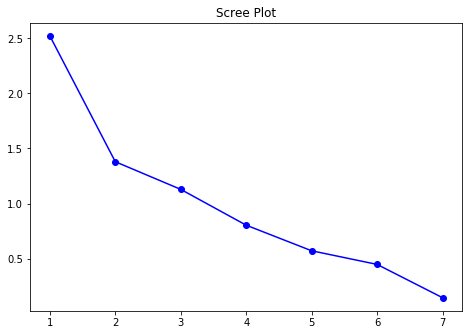

In [13]:
# means imputed
# scree plot - eigenvalues of correlation matrix
p=np.linalg.eig(indicators_mean_imputed.corr())
index = np.arange(len(p[0]))+1
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.plot(index, pd.Series(p[0]).sort_values(ascending=False), 'bo-')
ax.set_title('Scree Plot')

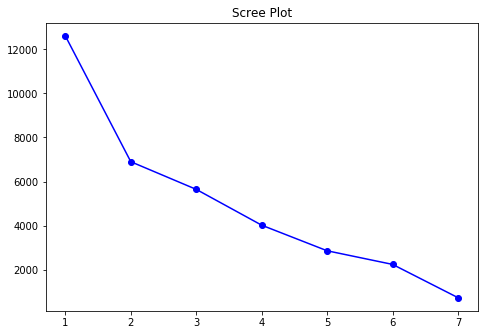

In [14]:
# Means imputed
# scree plot of the eigenvalues extracted by the statsmodels PCA
pca = smp.PCA(indicators_mean_imputed, method = 'nipals', ncomp=7)
scree(pca)

In [15]:
# means imputed
# let's go for 2 and also for 3 factors!

# Using PCA, then PAF below

pca2 = smp.PCA(indicators_mean_imputed, method = 'nipals', ncomp=2)
# sns.heatmap(pca2.loadings, annot = True)

In [16]:
pca3 = smp.PCA(indicators_mean_imputed, method = 'nipals', ncomp=3)
# sns.heatmap(pca3.loadings, annot = True)

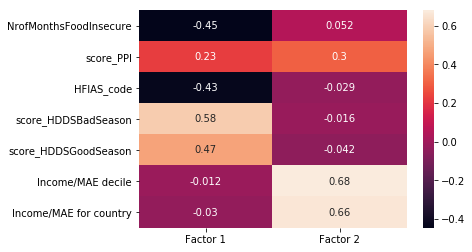

In [17]:
PCA2rotated = varimax(pca2.loadings)
pca2loadings = pd.DataFrame(PCA2rotated, index=indicators_mean_imputed.columns, columns = ['Factor 1', 'Factor 2'])
sns.heatmap(pca2loadings, annot=True)
# Factor 2 is money; factor 1 is weird - a kind of balance of food insecurity/quantity and diet quality

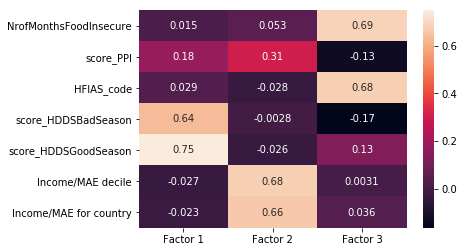

In [18]:
PCA3rotated = varimax(pca3.loadings)
pca3loadings = pd.DataFrame(PCA3rotated, index=indicators_mean_imputed.columns, columns = ['Factor 1', 'Factor 2', 'Factor 3'])
sns.heatmap(pca3loadings, annot=True)
# Factor 1 - diet quality; Factor 2 - Income (&PPI); Factor 3 - quantity of food. Simpler separation.

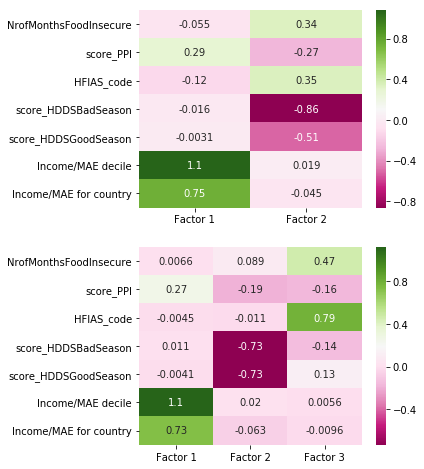

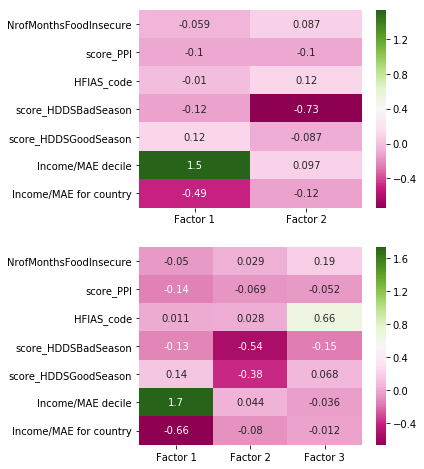

In [19]:
# and with PAF instead:
loadings_views, loadings_models = show_loadings(indicators_mean_imputed)
# loading matrices first, then score matrices
scores_view, scores_models = show_score_matrix(indicators_mean_imputed)

Text(0.5,1,'Scree Plot')

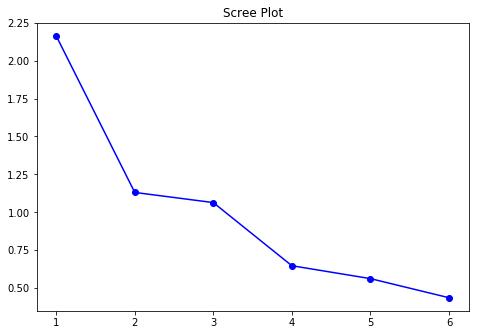

In [20]:
# Repeat but this time without income/MAE for country as so highly correlated
q=np.linalg.eig(indicators_mean_imputed.iloc[:,:6].corr())
index = np.arange(len(q[0]))+1
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.plot(index, pd.Series(q[0]).sort_values(ascending=False), 'bo-')
ax.set_title('Scree Plot')
# take 3 factors. more decisive scree this time

C:\Users\Clare\Anaconda3\lib\site-packages\statsmodels\multivariate\pca.py:228: ValueWarning: The requested number of components is more than can be computed from data. The maximum number of components is the minimum of the number of observations or variables
  warnings.warn(warn, ValueWarning)


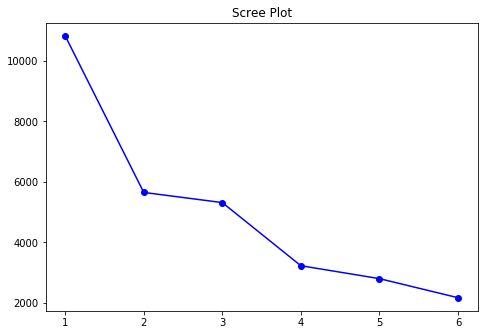

In [21]:
# and the other method for the scree
pca2 = smp.PCA(indicators_mean_imputed.iloc[:,:6], method = 'nipals', missing='drop-row', ncomp=7)
scree(pca2)

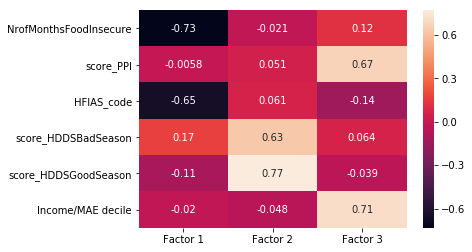

In [22]:
# PCA again
pca2 = smp.PCA(indicators_mean_imputed.iloc[:,:6], method = 'nipals', missing='drop-row', ncomp=3)
PCA2rotated = varimax(pca2.loadings)
pca2loadings = pd.DataFrame(PCA2rotated, index=indicators_mean_imputed.columns[:6], columns = ['Factor 1', 'Factor 2', 'Factor 3'])
sns.heatmap(pca2loadings, annot=True)

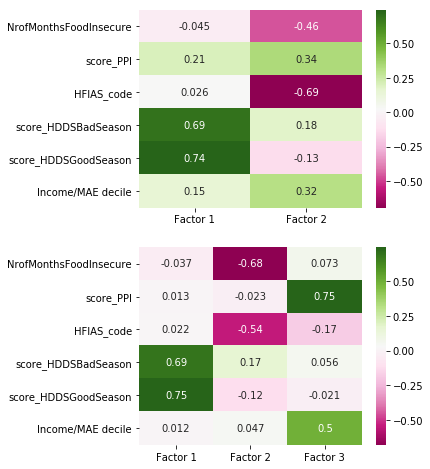

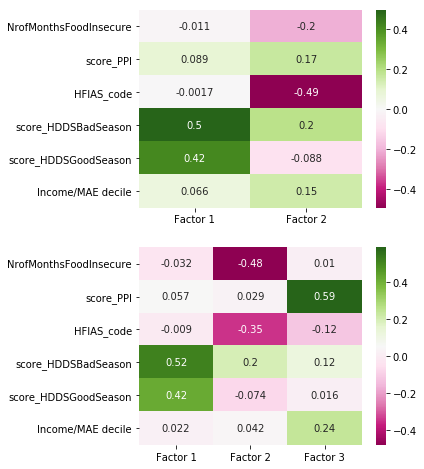

In [23]:
# AND WITH PAF (two and then three factors, loadings then scores):

loadings_views, loadings_models = show_loadings(indicators_mean_imputed.iloc[:,:6])
scores_views, scores_models = show_score_matrix(indicators_mean_imputed.iloc[:,:6])

In [24]:
# Again PPI and income decile load onto the same factor
# Factor 1 - Quality of diet (or lack thereof)
# Factor 2 - Quantity of food
# Factor 3 - Relative income
# I think that this is more helpful

# see bottom for results from other imputations, as I think they are spurious for doing factor analysis

# going forward with the 3 factor model in both cases.

In [25]:
# check that these matrices behave as I expect...

np.array(pca2loadings.transpose()) @ np.array(pca2loadings)
# yes, this is approximately the identity. good

array([[  1.00000000e+00,  -3.74700271e-16,  -6.61797006e-16],
       [ -3.74700271e-16,   1.00000000e+00,  -8.32667268e-17],
       [ -6.61797006e-16,  -8.32667268e-17,   1.00000000e+00]])

In [26]:
np.array(pca2loadings) @ np.array(pca2loadings).transpose() # why is that not also identity??!?


array([[ 0.55213944,  0.08302851,  0.45902613, -0.1279031 ,  0.05752757,
         0.10007064],
       [ 0.08302851,  0.45533832, -0.0863872 ,  0.07444338,  0.01355184,
         0.47741322],
       [ 0.45902613, -0.0863872 ,  0.44559849, -0.07916423,  0.12128722,
        -0.08885481],
       [-0.1279031 ,  0.07444338, -0.07916423,  0.43126006,  0.46578272,
         0.0123805 ],
       [ 0.05752757,  0.01355184,  0.12128722,  0.46578272,  0.60464326,
        -0.06239054],
       [ 0.10007064,  0.47741322, -0.08885481,  0.0123805 , -0.06239054,
         0.51102043]])

In [27]:
# these are much further from the identity!!
np.array(loadings_views[1]) @ np.array(scores_views[1]).transpose()

array([[ 0.32871813,  0.02115539,  0.22678876, -0.14486885,  0.03599831,
        -0.01182106],
       [ 0.01823781,  0.43741308, -0.08078907,  0.09260585,  0.01880522,
         0.17879193],
       [ 0.25818784, -0.11662866,  0.20807255, -0.11711639,  0.04664045,
        -0.0643041 ],
       [-0.10116111,  0.07707324, -0.07026305,  0.39904769,  0.27951205,
         0.03546605],
       [ 0.03189189,  0.0267181 ,  0.03592976,  0.36118951,  0.32128197,
         0.00618336],
       [-0.01821985,  0.29351415, -0.07565285,  0.07585116,  0.00921756,
         0.12187634]])

In [28]:
np.array(loadings_views[1]).transpose() @ np.array(scores_views[1])

array([[ 0.67439638,  0.09295749,  0.1034599 ],
       [ 0.06341442,  0.55706211,  0.07392349],
       [ 0.07254385,  0.08009682,  0.58495126]])

In [29]:
# compute factor scores manually; this is a useful process as I want to blank out small values for better separation of factors
# (so easier interpretation)

indicators_for_facs=normalise(indicators_mean_imputed[indicators_mean_imputed.columns[:6]])

C:\Users\Clare\Anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


for column  NrofMonthsFoodInsecure , the mean was  2.2441551540912914  and the standard deviation was  1.7706358498970178
for column  score_PPI , the mean was  44.0214333556603  and the standard deviation was  17.374842891740744
for column  HFIAS_code , the mean was  1.7716518800169088  and the standard deviation was  1.1932794809446847
for column  score_HDDSBadSeason , the mean was  4.205571565802183  and the standard deviation was  2.3529371879879974
for column  score_HDDSGoodSeason , the mean was  5.9817598717177765  and the standard deviation was  2.2951517540197965
for column  Income/MAE decile , the mean was  4.4856  and the standard deviation was  2.8796269012178857


C:\Users\Clare\Anaconda3\lib\site-packages\pandas\core\indexing.py:601: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value


In [30]:
# calculating the scores
pca_scores = factor_scores(indicators_for_facs,pca2loadings, names=['Food Security PCA','Diet Quality PCA','Money PCA'])

In [31]:
paf_scores_array = scores_models[1].factor_scoring(method = 'regression')

In [32]:
paf_scores = pd.DataFrame(paf_scores_array, columns = ['Diet Quality PAF','Food Security PAF','Money PAF'])

In [33]:
scores = pd.concat([pca_scores, paf_scores], axis=1)

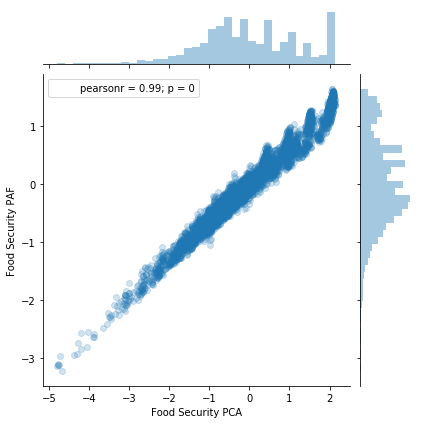

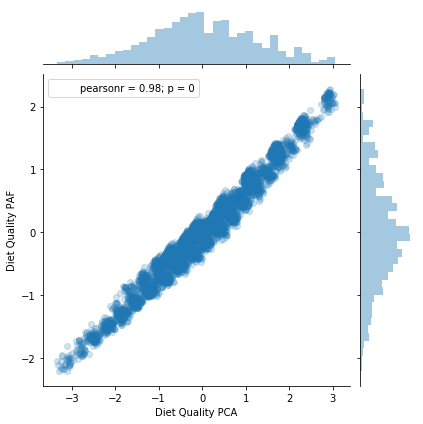

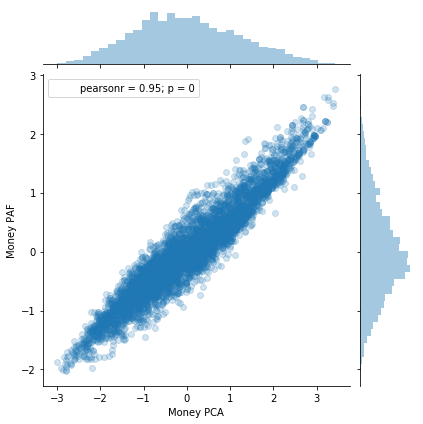

In [34]:
# see how they compare to each other

sns.jointplot(x='Food Security PCA', y='Food Security PAF', data = scores, alpha = .2)
sns.jointplot(x='Diet Quality PCA', y='Diet Quality PAF', data = scores, alpha = .2)
sns.jointplot(x='Money PCA', y='Money PAF', data = scores, alpha = .2)
# the factor scores are very very similar, unsurprisingly

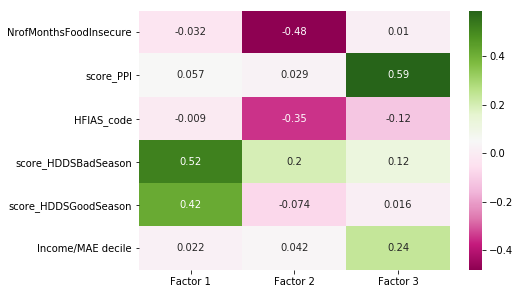

In [35]:
fig = plt.figure()
axes = fig.add_axes([.3,.1,.9,.9])
sns.heatmap(scores_views[1], annot=True, cmap='PiYG', ax=axes).figure.savefig("3 01 paf score matrix before dropping")

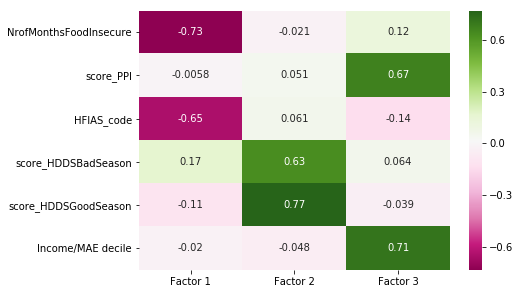

In [36]:
fig = plt.figure()
axes = fig.add_axes([.3,.1,.9,.9])
sns.heatmap(pca2loadings, annot=True, cmap='PiYG',ax=axes).figure.savefig("3 02 pca score matrix before dropping")

In [37]:
# next: check that the PAF scores are from multiplying the score matrix by the observations - have checked, they are.
# recalculate with small loadings/score coefficients omtted
# for FI missing, increase impact of HFIAS code
#compare again.


In [38]:
# for better interpretation, drop the small coefficients

paf_score_coeff = scores_views[1].copy()
pca_score_coeff = pca2loadings.copy()
for i in range(3):
    paf_score_coeff[paf_score_coeff.columns[i]] = np.where(abs(paf_score_coeff[paf_score_coeff.columns[i]])<.3,
                                                           0,paf_score_coeff[paf_score_coeff.columns[i]])
    pca_score_coeff[pca_score_coeff.columns[i]] = np.where(abs(pca_score_coeff[pca_score_coeff.columns[i]])<.3,
                                                           0,pca_score_coeff[pca_score_coeff.columns[i]])
fig = plt.figure()
axes = fig.add_axes([.3,.1,.9,.9])
sns.heatmap(paf_score_coeff, annot=True, ax=axes cmap='PiYG').figure.savefig("3 03 paf score matrix after dropping")

SyntaxError: invalid syntax (<ipython-input-38-920bee471ec4>, line 12)

In [ ]:
fig = plt.figure()
axes = fig.add_axes([.3,.1,.9,.9])
sns.heatmap(pca_score_coeff, annot=True,ax=axes, cmap='PiYG').figure.savefig("3 04 pca score matrix after dropping")

In [ ]:
# calculate factor scores manually in both cases
# see how they compare again

pca_scores = factor_scores(indicators_for_facs,pca_score_coeff, names=['Food Security PCA','Diet Quality PCA','Money PCA'])
paf_scores = factor_scores(indicators_for_facs,paf_score_coeff, names=['Diet Quality PAF','Food Security PAF','Money PAF'])
scores_drop_small = pd.concat ([pca_scores, paf_scores], axis=1)
sns.jointplot(x='Food Security PCA', y='Food Security PAF', data = scores_drop_small, alpha = .2)
sns.jointplot(x='Diet Quality PCA', y='Diet Quality PAF', data = scores_drop_small, alpha = .2)
sns.jointplot(x='Money PCA', y='Money PAF', data = scores_drop_small, alpha = .2)

In [ ]:
# dropping small coefficients has meant focusing on the points where they agree - less noise - so closer

In [ ]:
# check how factors are correlated in each case
# this is the big difference
# there is much more correlation between the factors in the PAF case

# PCA, before dropping the little ones
fig = plt.figure()
axes = fig.add_axes([.3,.1,.9,.9])
sns.heatmap(scores[scores.columns[:3]].corr(), ax=axes, annot=True, cmap='BuPu', center = .2).figure.savefig('3 05 factor correlations before drop PCA')

In [ ]:
# PAF, before dropping the little ones. Much less correlation!
fig = plt.figure()
axes = fig.add_axes([.3,.1,.9,.9])
sns.heatmap(scores[scores.columns[3:]].corr(), annot=True, cmap='BuPu', ax=axes, center = .2).figure.savefig('3 06 factor correlations before drop PAF')

In [ ]:
# PCA after dropping the little ones - little change
fig = plt.figure()
axes = fig.add_axes([.3,.1,.9,.9])
sns.heatmap(scores_drop_small[scores.columns[:3]].corr(), annot=True,ax=axes, cmap='BuPu', center = .2).figure.savefig('3 07 factor correlations after drop PCA')

In [ ]:
# PAF after dropping the little ones - the little ones are where the factors are allowed to correlate!
fig = plt.figure()
axes = fig.add_axes([.3,.1,.9,.9])
sns.heatmap(scores_drop_small[scores.columns[3:]].corr(), annot=True, cmap='BuPu', ax=axes, center = .2).figure.savefig('3 08 factor correlations after drop PAF')

# This is tricky. Information has been lost in this part of the process.
# But the purpose of factor analysis is to ease interpretation, and interpretation is much easier with separated factors

In [ ]:
# NrofMonthsFoodInsecure had a lot of missing values.
# For these, I'd like to amplify the effect of HFIAS code (which loads onto the same factor),
# instead of using the imputed mean of NrofMonthsFoodInsecure.

scores_drop_small['Food Security PAF']=np.where(indicators['FI missing']==1,
                                     indicators_for_facs['HFIAS_code']*(paf_score_coeff.loc['HFIAS_code','Factor 2']+paf_score_coeff.loc['NrofMonthsFoodInsecure','Factor 2']),
                                     scores_drop_small['Food Security PAF'])
scores_drop_small['Food Security PCA']=np.where(indicators['FI missing']==1,
                                     indicators_for_facs['HFIAS_code']*(pca_score_coeff.loc['HFIAS_code','Factor 1']+pca_score_coeff.loc['NrofMonthsFoodInsecure','Factor 1']),
                                     scores_drop_small['Food Security PCA'])
indicators_scores = pd.concat([indicators, scores_drop_small], axis = 1)

In [ ]:
# now look at the correlations between the factor scores - little change since last time.
fig = plt.figure()
axes = fig.add_axes([.3,.1,.9,.9])
sns.heatmap(indicators_scores[['Food Security PCA', 'Diet Quality PCA', 'Money PCA']].corr(), annot=True, ax=axes, cmap='BuPu', center = .2).figure.savefig('3 09 factor correlations PCA final')


In [ ]:
fig = plt.figure()
axes = fig.add_axes([.3,.1,.9,.9])
sns.heatmap(indicators_scores[['Diet Quality PAF', 'Food Security PAF', 'Money PAF']].corr(),ax=axes, annot=True, cmap='BuPu', center = .2).figure.savefig('3 10 factor correlations PAF final')

In [ ]:
# CHECK HOW THE SCATTERS COMPARE

sns.jointplot(x='Food Security PCA', y='Food Security PAF', data = indicators_scores, alpha = .2).savefig('3 11 food security PCA vs PAF scores')
sns.jointplot(x='Diet Quality PCA', y='Diet Quality PAF', data = indicators_scores, alpha = .2).savefig('3 12 diet quality PCA vs PAF scores')
sns.jointplot(x='Money PCA', y='Money PAF', data = scores_drop_small, alpha = .2).savefig('3 13 money PCA vs PAF scores')

In [ ]:
# save outfile
indicators_scores.to_csv("3PCAonImputedValues_output")

In [ ]:
# Don't really know which to use - but will stick with both for now. PCA still seems easier to interpret;
# PAF seems to give nicer distributions,
# I'll try both.

# Below - archive. Error message to prevent it from running automatically.
sns.hello()

In [ ]:
indicators_scores.columns

In [ ]:
# PCA WITH MEDIAN IMPUTATION
indicators_success=indicators[['NrofMonthsFoodInsecure','score_PPI','HFIAS_code','score_HDDSBadSeason', 'score_HDDSGoodSeason',
                               'Income/MAE decile']]
indicators_success_median=indicators[['FIfromMedian','score_PPI','HFIAS_code','score_HDDSBadSeason', 'score_HDDSGoodSeason',
                               'Income/MAE decile']]
# indicators_success_mean=indicators[['FIfromMean','score_PPI','HFIAS_code','score_HDDSBadSeason', 'score_HDDSGoodSeason',
           #                    'Income/MAE decile']]
indicators_success_tree=indicators[['FI imputed pure','score_PPI','HFIAS_code','score_HDDSBadSeason', 'score_HDDSGoodSeason',
                               'Income/MAE decile']]


In [ ]:
# see how the different imputations affect correlations - very little.
fig = plt.figure(figsize = (6,30))
axes = fig.subplots(4, gridspec_kw={"hspace":.6})
descriptions = ["Original","Mean imputation","Median imputation","Tree imputation"]
indicator_sets =[indicators_success,indicators_mean_imputed[indicators_mean_imputed.columns[:6]],indicators_success_median,indicators_success_tree]
for i in range(4):
    sns.heatmap(indicator_sets[i].corr(method = 'spearman'),annot=True, center=1, ax=axes[i])
    axes[i].set_title(descriptions[i])
    

In [ ]:
# manually plot scree plots of the three different imputations
fig = plt.figure(figsize = (13,3))
axes = fig.subplots(1,3)
for i in range (3):
    q=np.linalg.eig(indicator_sets[i+1].corr())
    index = np.arange(len(q[0]))+1
    axes[i].plot(index, pd.Series(q[0]).sort_values(ascending=False), 'bo-')
    axes[i].set_title('Scree Plot '+descriptions[i+1])
# all suggest extraction of 3 factors

In [ ]:

for i in range(3):
    pca = smp.PCA(indicator_sets[i+1], method = 'nipals', missing='drop-row', ncomp=7)
    print(descriptions[i+1])
    scree(pca)
# Again all suggest 3 factor solution

In [ ]:
# extract factors and compare loading matrices
fig = plt.figure(figsize = (15,3))
axes = fig.subplots(1,3, gridspec_kw={'wspace':1})
pca2loadings = [[],[],[]]
for i in range(3):
    pca2 = smp.PCA(indicator_sets[i+1], method = 'nipals', missing='drop-row', ncomp=3)
    PCA2rotated = varimax(pca2.loadings)
    pca2loadings[i] = pd.DataFrame(PCA2rotated, index=indicator_sets[i+1].columns, columns = ['Factor 1', 'Factor 2', 'Factor 3'])
    sns.heatmap(pca2loadings[i], annot=True, ax=axes[i])
    axes[i].set_title(descriptions[i+1])

In [ ]:
# extract factors and compare loading matrices
fig = plt.figure(figsize = (12,10))
axes = fig.subplots(2,2, gridspec_kw={'hspace':.2, 'wspace':.7})
pca2loadings = [[],[],[],[]]
for i in range(4):
    pca2 = smp.PCA(indicator_sets[i], method = 'nipals', missing='drop-row', ncomp=3)
    PCA2rotated = varimax(pca2.loadings)
    pca2loadings[i] = pd.DataFrame(PCA2rotated, index=indicator_sets[i].columns, columns = ['Factor 1', 'Factor 2', 'Factor 3'])
    sns.heatmap(pca2loadings[i], annot=True, ax=axes[int(np.divide(i,2)),np.remainder(i,2)])
    axes[int(np.divide(i,2)),np.remainder(i,2)].set_title(descriptions[i])

In [ ]:
# What's going on; the imputation using the mean is the one which differs the most from the original.
# the original dropped the rows where there were missing values, thus losing information.
# the median and tree imputations attempted to fill these rows by using the available rows.
# this creates relatioships between the data, and by assuming that these rows are the same as the others, perhaps we get no more
#     information from them.

# the mean imputation means that where a data point is missing, that point takes the neutral value - ie nothing is added or 
# subtracted for that observation of that variable. 

# I think that what these differences tell us is that the missing values are not missing at random, and it is
# not prudent to impute them from these other indicators, as including the best part of these rows with the values treated as
# missing, rather than as found from the rest of the data, yields different results.



In [ ]:
indicators_mean_imputed.describe()
# all of these indicators have a natural maximum with which to work, it would be nice to have 
# meaningful maximum factor scores.

In [ ]:
loadings = pca2loadings[1]
indicator_sets[1].head()

In [ ]:
indicators_for_facs.head()

In [ ]:
sns.heatmap(loadings, annot=True)
# note that the negative ones are good: having low nr of months food insecure and HFIAS 0 indicates food security

In [ ]:
# for better interpretation, drop the small coefficients
for i in range(3):
    loadings[loadings.columns[i]] = np.where(abs(loadings[loadings.columns[i]])<.3,0,loadings[loadings.columns[i]])
fig = sns.heatmap(loadings, annot=True)


In [ ]:
inds_with_scores = pd.concat([indicators,fac_scores],axis=1)
inds_with_scores.head()

In [ ]:
# drop redundant columns
inds_with_scores.drop(['Unnamed: 0', 'Unnamed: 0.1','imputed FI','imputed FI pure'],axis=1,inplace=True)

In [ ]:
inds_with_scores.to_csv("3PCAonImputedValues_output")

In [ ]:
# just a quick check
# factor analysis states that x = LF
# so...
factor_scores(inds_with_scores[['Food Security Factor','Diet Quality Factor','Money Factor']], loadings.transpose())

In [ ]:
temp = normalise(indicator_sets[1])
temp.head()

In [ ]:
inds_with_scores.columns

In [ ]:
inds_with_scores[['NrofMonthsFoodInsecure', 'score_PPI','score_HDDSGoodSeason','score_HDDSBadSeason','HFIAS_code','Income/MAE decile',
                  'Food Security Factor','Diet Quality Factor', 'Money Factor']]